# Exciton Model for independent calculations of vdWHs

In [25]:
# !cp ../../hetereostructure_results/vdWHs_* -r ./

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import ase.units
from default_parameters import get_thickness

Hartree = ase.units.Hartree
Bohr = ase.units.Bohr

In [27]:
%matplotlib inline

In [28]:
from matplotlib import rcParams
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

**Note for variable naming:** I_ for "Independently calculated", P_ for "Precalculated" (from 2D database)

## Independent calulations were done with
- eig_xc = LDA
- eig_ecut = 500
- ecut = 50
- domega = 0.05
- omega2 = 10
- eta = 0.001
- qmax = 3.0

In [29]:
# Load vdWH. I_ for "Independently calculated", P_ for "Precalculated" (from 2D database)
nFilling = 3
nPadding = 0
I_vdWH = np.load('independent_vdWHs_nFilling={}_nPadding={}.npz'.format(nFilling, nPadding))
P_vdWH = np.load('vdWHs_nFilling={}_nPadding={}.npz'.format(nFilling, nPadding))
materials = I_vdWH['materials'][:-1]
bilayers = ['n-WS2, p-WSe2']

In [30]:
I_E_b_heat_mat = I_vdWH['E_b_heat_mat'][:-1,:-1]
I_E_b_heat_xlabels = I_vdWH['E_b_heat_xlabels'][:-1]
I_E_b_heat_ylabels = I_vdWH['E_b_heat_ylabels'][:-1]

In [31]:
def heatmap(data, xlabels, ylabels, cbarlabel, **kwargs):
    # if not ax:
    #     ax = plt.gca()
    f = plt.gcf()
    plt.imshow(data, **kwargs)
    plt.xticks(np.arange(len(xlabels)), labels=xlabels)
    plt.yticks(np.arange(len(ylabels)), labels=ylabels)
    im_ratio = data.shape[0]/data.shape[1]
    plt.colorbar(label=cbarlabel,fraction=0.046*im_ratio, pad=0.04)
    # cbar.ax.set_ylabel(cbarlabel, rotation=0, va="bottom")

    # Loop over data dimensions and create text annotations.
    for i in range(len(ylabels)):
        for j in range(len(xlabels)):
            colors = ['k', 'w']
            color = colors[int(data[i,j] > np.mean(data))]
            plt.text(j, i, data[i, j], ha="center", va="center", color=color)

Exciton binding energies for different
 bilayer combinations with 0 encapsulating and 3 inner hBN layers


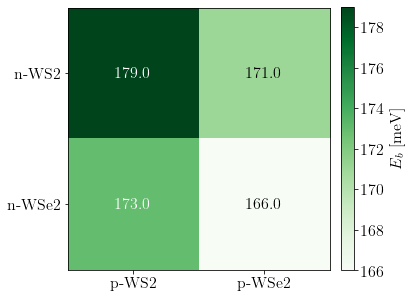

In [32]:
fig = plt.figure(1, figsize=(6,6))

description = 'Exciton binding energies for different\n bilayer combinations with {} encapsulating and {} inner hBN layers'.format(nPadding, nFilling)
print(description)
heatmap(np.round(I_E_b_heat_mat*10**3),
    I_E_b_heat_xlabels, I_E_b_heat_ylabels, cbarlabel=r'$E_b$ [meV]',
    cmap='Greens')
plt.tight_layout()
plt.savefig('./plots/I_vdWH_E_b.pdf')
plt.savefig('./plots/I_vdWH_E_b.png')
plt.show()

In [33]:
def read_bilayer(bilayer, vdWH):
    '''@returns U_ee, U_eh, U_eh_r, epsM, E_b
    '''
    i = list(vdWH['bilayer']).index(bilayer)
    U_ee = vdWH['U_ee'][i]
    U_eh = vdWH['U_eh'][i]
    U_eh_r = vdWH['U_eh_r'][i]
    epsM = vdWH['epsM'][i]
    E_b = vdWH['E_b'][i]
    return U_ee, U_eh, U_eh_r, epsM, E_b

In [34]:
I_r = I_vdWH['r']
I_q = I_vdWH['q']

P_r = P_vdWH['r']
P_q = P_vdWH['q']
q_anal = np.linspace(0.0001, P_q[-1], 300)
r_anal = np.linspace(0, P_r[-1], 10000)
eps_const = 2
U_ee_2D_coulomb = (2*np.pi/eps_const) * 1/np.abs(q_anal*Bohr)

d_BN = get_thickness('BN')
d_barrier = nFilling*d_BN
U_eh_2D_coulomb = -U_ee_2D_coulomb*np.exp(-(d_barrier/Bohr)*(q_anal*Bohr))

U_eh_2D_coulomb_r = Hartree * (1/eps_const) * 1/np.sqrt((r_anal/Bohr)**2 + (d_barrier/Bohr)**2)

In [35]:
def get_color(E_b, vdWH, cmap='Blues'):
    cmap = plt.get_cmap(cmap)

    E_bs = vdWH['E_b']
    def get_relative_percentile(x, min_p):
        E_b_min = np.min(E_bs)
        return (1-min_p)*(x - E_b_min)/np.max(E_bs - E_b_min)

    min_p = 0.6
    p = get_relative_percentile(E_b, min_p)
    return cmap(min_p + p)
markers = ['-', '--', ':']

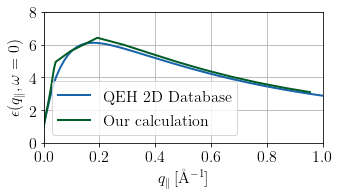

In [36]:
q_i_start = 0
plt.figure(2, figsize=(5,3))
# plt.plot(np.linspace(0,1, 200), eps_const*np.ones(200),'k-', label=r'$\epsilon = 2$')
for (i, bilayer) in enumerate(bilayers):
    _, _, _, P_epsM, P_E_b = read_bilayer(bilayer, P_vdWH)
    plt.plot(P_q[q_i_start:], P_epsM[q_i_start:].real, markers[i % len(markers)], linewidth=2, label='QEH 2D Database', color=get_color(P_E_b, P_vdWH, 'Blues'))
    _, _, _, I_epsM, I_E_b = read_bilayer(bilayer, I_vdWH)
    plt.plot(I_q[q_i_start:], I_epsM[q_i_start:].real, markers[i % len(markers)], linewidth=2, label='Our calculation', color=get_color(I_E_b, I_vdWH, 'Greens'))
plt.xlim(0,1)
plt.ylim(0,8)
plt.xlabel(r'$q_\parallel \, [\mathrm{\AA^{-1}}$]')
plt.ylabel(r'$\epsilon(q_\parallel, \omega=0)$')
plt.legend()
# plt.title("Screened potential for all materials")
plt.grid()
plt.tight_layout()
plt.savefig('./plots/I_vdWH_dielectric_func.pdf')
plt.savefig('./plots/I_vdWH_dielectric_func.png')
plt.show()

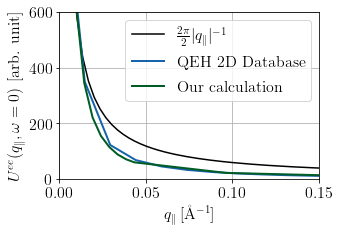

In [37]:
q_i_start = 2
plt.figure(3, figsize=(5,3.5))
plt.plot(q_anal, U_ee_2D_coulomb,'k-', label=r'$\frac{ 2\pi}{ 2 } |q_\parallel|^{-1}$')
for (i, bilayer) in enumerate(bilayers):
    P_U_ee, _, _, _, P_E_b = read_bilayer(bilayer, P_vdWH)
    plt.plot(P_q[q_i_start:], P_U_ee[q_i_start:].real, markers[i % len(markers)], linewidth=2, label='QEH 2D Database', color=get_color(P_E_b, P_vdWH, cmap='Blues'))
    I_U_ee, _, _, _, I_E_b = read_bilayer(bilayer, I_vdWH)
    plt.plot(I_q[q_i_start:], I_U_ee[q_i_start:].real, markers[i % len(markers)], linewidth=2, label='Our calculation', color=get_color(I_E_b, I_vdWH, cmap='Greens'))
plt.xlim(0,0.15)
plt.ylim(0,600)
plt.xlabel(r'$q_\parallel \, [\mathrm{\AA^{-1}}$]')
plt.ylabel(r'$U^{ee}(q_\parallel, \omega=0)$ [arb. unit]')
plt.legend()
# plt.title("Screened potential for all materials")
plt.grid()
plt.tight_layout()
plt.savefig('./plots/I_vdWH_U_ee.pdf')
plt.savefig('./plots/I_vdWH_U_ee.png')
plt.show()

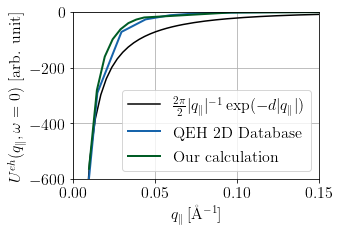

In [38]:
q_i_start = 2
plt.figure(4, figsize=(5,3.5))
plt.plot(q_anal, U_eh_2D_coulomb,'k-', label=r'$\frac{ 2\pi }{ 2 } |q_\parallel|^{-1} \exp(-d |q_\parallel|) $')
for (i, bilayer) in enumerate(bilayers):
    _, P_U_eh, _, _, P_E_b = read_bilayer(bilayer, P_vdWH)
    plt.plot(P_q[q_i_start:], P_U_eh[q_i_start:].real, markers[i % len(markers)], linewidth=2, label='QEH 2D Database', color=get_color(P_E_b, P_vdWH, cmap='Blues'))
    _, I_U_eh, _, _, I_E_b = read_bilayer(bilayer, I_vdWH)
    plt.plot(I_q[q_i_start:], I_U_eh[q_i_start:].real, markers[i % len(markers)], linewidth=2, label='Our calculation', color=get_color(I_E_b, I_vdWH, cmap='Greens'))
plt.xlim(0,0.15)
plt.ylim(-600,0)
plt.xlabel(r'$q_\parallel \, [\mathrm{\AA^{-1}}$]')
plt.ylabel(r'$U^{eh}(q_\parallel, \omega=0)$ [arb. unit]')
plt.legend()
# plt.title("Screened potential for all materials")
plt.grid()
plt.tight_layout()
plt.savefig('./plots/I_vdWH_U_eh.pdf')
plt.savefig('./plots/I_vdWH_U_eh.png')
plt.show()

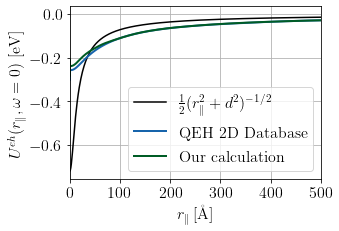

In [39]:
plt.figure(5, figsize=(5,3.5))
plt.plot(r_anal, -U_eh_2D_coulomb_r,'k-', label=r'$\frac{ 1 }{ 2 } (r_\parallel^2 + d^2)^{-1/2}$')
for (i, bilayer) in enumerate(bilayers):
    _, _, P_U_eh_r, _, P_E_b = read_bilayer(bilayer, P_vdWH)
    plt.plot(P_r, P_U_eh_r, markers[i % len(markers)], linewidth=2, label='QEH 2D Database', color=get_color(P_E_b, P_vdWH, cmap='Blues'))
    _, _, I_U_eh_r, _, I_E_b = read_bilayer(bilayer, I_vdWH)
    plt.plot(I_r, I_U_eh_r, markers[i % len(markers)], linewidth=2, label='Our calculation', color=get_color(I_E_b, I_vdWH, cmap='Greens'))
plt.xlim(0,500)
# plt.ylim(-300,0)
plt.xlabel(r'$r_\parallel \, [\mathrm{Å}$]')
plt.ylabel(r'$U^{eh}(r_\parallel, \omega=0)$ [eV]')
plt.legend()
# plt.title("Screened potential for all materials")
plt.grid()
plt.tight_layout()
plt.savefig('./plots/I_vdWH_U_eh_r.pdf')
plt.savefig('./plots/I_vdWH_U_eh_r.png')
plt.show()

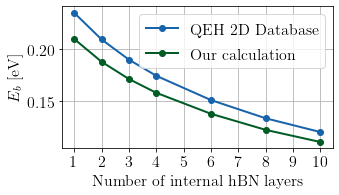

In [40]:
plt.figure(6, figsize=(5,3))
nPadding = 0
fillings = [1, 2, 3, 4, 6, 8, 10]
I_E_bs = np.zeros(len(fillings))
P_E_bs = np.zeros(len(fillings))
for (i, bilayer) in enumerate(bilayers):
    for (j, nFilling) in enumerate(fillings):
        P_vdWH_filling = np.load('vdWHs_nFilling={}_nPadding={}.npz'.format(nFilling, nPadding))
        _, _, _, _, P_E_bs[j] = read_bilayer(bilayer, P_vdWH_filling)
    plt.plot(fillings, P_E_bs, markers[i % len(markers)] + 'o', linewidth=2, label='QEH 2D Database', color=get_color(P_E_bs[2], P_vdWH, cmap='Blues'))

    for (j, nFilling) in enumerate(fillings):
        I_vdWH_filling = np.load('independent_vdWHs_nFilling={}_nPadding={}.npz'.format(nFilling, nPadding))
        _, _, _, _, I_E_bs[j] = read_bilayer(bilayer, I_vdWH_filling)
    plt.plot(fillings, I_E_bs, markers[i % len(markers)] + 'o', linewidth=2, label='Our calculation', color=get_color(I_E_bs[2], I_vdWH, cmap='Greens'))
plt.legend()
plt.xticks(np.arange(1,11))
plt.xlabel(r'Number of internal hBN layers')
plt.ylabel(r'$E_b$ [eV]')
plt.grid()
plt.tight_layout()
plt.savefig('./plots/I_vdWH_E_b_filling.pdf')
plt.savefig('./plots/I_vdWH_E_b_filling.png')
plt.show()

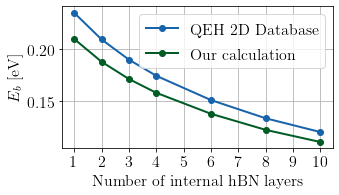

In [47]:
plt.figure(6, figsize=(5,3))
nPadding = 0
fillings = [1, 2, 3, 4, 6, 8, 10]
I_E_bs = np.zeros(len(fillings))
P_E_bs = np.zeros(len(fillings))
for (i, bilayer) in enumerate(bilayers):
    for (j, nFilling) in enumerate(fillings):
        P_vdWH_filling = np.load('vdWHs_nFilling={}_nPadding={}.npz'.format(nFilling, nPadding))
        _, _, _, _, P_E_bs[j] = read_bilayer(bilayer, P_vdWH_filling)
    plt.plot(fillings, P_E_bs, markers[i % len(markers)] + 'o', linewidth=2, label='QEH 2D Database', color=get_color(P_E_bs[2], P_vdWH, cmap='Blues'))

    for (j, nFilling) in enumerate(fillings):
        I_vdWH_filling = np.load('independent_vdWHs_nFilling={}_nPadding={}.npz'.format(nFilling, nPadding))
        _, _, _, _, I_E_bs[j] = read_bilayer(bilayer, I_vdWH_filling)
    plt.plot(fillings, I_E_bs, markers[i % len(markers)] + 'o', linewidth=2, label='Our calculation', color=get_color(I_E_bs[2], I_vdWH, cmap='Greens'))
plt.legend()
plt.xticks(np.arange(1,11))
plt.xlabel(r'Number of internal hBN layers')
plt.ylabel(r'$E_b$ [eV]')
plt.grid()
plt.tight_layout()
plt.savefig('./plots/I_vdWH_E_b_filling.pdf')
plt.savefig('./plots/I_vdWH_E_b_filling.png')
plt.show()